In [1]:
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def load_dataset(up_to= None):
    '''
    Charge les fichiers DVF jusqu'à une année donnée (incluse).

    Paramètres:
        up_to (str): Année maximale à charger, ex: "2020", "2023".

    Return:
        DataFrame Pandas combiné sans doublons.
    '''

    data_files = {
        "2019": "data/ValeursFoncieres-2019-S2.txt",
        "2020": "data/ValeursFoncieres-2020.txt",
        "2021": "data/ValeursFoncieres-2021.txt",
        "2022": "data/ValeursFoncieres-2022.txt",
        "2023": "data/ValeursFoncieres-2023.txt",
        "2024": "data/ValeursFoncieres-2024-S1.txt",
    }

    valid_years = list(data_files.keys())
    if (up_to is not None) and (up_to not in valid_years):
        print("Erreur: \"up_to\" doit être une année entre \"2019\" et \"2024\".")
        return -1

    data_list = []
    for year, path in data_files.items():
        print(f"Chargement {year}...")
        df = pd.read_csv(path, delimiter='|', dtype= str)
        data_list.append(df)
        if (up_to is not None) and (year == up_to):
            break

    data = pd.concat(data_list, ignore_index= True)
    # data.drop_duplicates(inplace=True) #? Fait crash le kernel, désactivé pour le moment
    print(f"\n{len(data):,} lignes chargées au total.")

    return data

In [ ]:
def parse_dataset(data, min_price= 1_000, max_price= 2_000_000, all_local_type= False):
    '''
    Parsing des données, on ne garde que les lignes des ventes et de certains types de local.
    Seule les colonnes suivantes sont gardées : "Valeur fonciere", "Date mutation", "Code departement", "Type local", "Surface terrain", "Surface reelle bati", "Nombre pieces principales".
    Les lignes comportant des NaN sont supprimées.
    Ajout de colonnes pour "Année", "Mois", "Jour".
    Valeurs de target plafonnée.

    Paramètres:
        data (DataFrame): strucutre d'un fichier DVF.
        max_price (float): valeur maximum de target.
        all_local_type (bool): définit si l'on exclu certains types de local ou non.

    Retour:
        DataFrames Pandas, X contenant les features et y contenant la target.
    '''

    if max_price < 0:
        print("Erreur: \"max_price\" doit être > 0.")
        return -1
    if min_price < 0:
        print("Erreur: \"max_price\" doit être > 0.")
        return -1
    if min_price >= max_price:
        print("Erreur: \"min_price\" doit être < à \"max_price\"")
        return -1
    if (all_local_type is not False) and (all_local_type is not True):
        print("Erreur: \"all_local_type\" doit être un booleen.")
        return -1

    data = data[(data["Nature mutation"] == "Vente")]

    if all_local_type == False:
        data = data[(data["Type local"] == "Maison") | (data["Type local"] == "Appartement")]

    data = data.dropna(subset= ["Date mutation", "Valeur fonciere", "Code departement", "Type local", "Surface reelle bati", "Nombre pieces principales", "Surface terrain"])
    data["Valeur fonciere"] = data["Valeur fonciere"].str.replace(",", ".", regex= False).astype(float)
    data["Date mutation"] = pd.to_datetime(data["Date mutation"], format="%d/%m/%Y", errors="coerce")
    data["Annee"] = data["Date mutation"].dt.year
    data["Mois"] = data["Date mutation"].dt.month
    data["Jour"] = data["Date mutation"].dt.day
    data["Surface reelle bati"] = data["Surface reelle bati"].str.replace(",", ".", regex= False).astype(float)
    data["Nombre pieces principales"] = data["Nombre pieces principales"].astype(int)
    data["Surface terrain"] = data["Surface terrain"].str.replace(",", ".", regex= False).astype(float)
    data["Prix au m2"] = data["Valeur fonciere"] / data["Surface reelle bati"]

    data = data[(data["Valeur fonciere"] >= min_price) &
                (data["Valeur fonciere"] <= max_price) & 
                (data["Surface reelle bati"] >= 15) &
                (data["Surface reelle bati"] <= 300) &
                (data["Surface terrain"] <= 10_00) &
                (data["Nombre pieces principales"] >= 1) &
                (data["Nombre pieces principales"] <= 12)
                # (data["Prix au m2"] >= 300) &
                # (data["Prix au m2"] <= 10_000)
                ]

    features = ["Date mutation", "Code departement", "Type local", "Surface terrain", "Surface reelle bati", "Nombre pieces principales", "Annee", "Mois", "Jour", "Prix au m2"]
    target = "Valeur fonciere"

    return data, features, target

In [3]:
data = load_dataset(up_to= "2021") #TODO crash toujour lorsque load au dessus de 2021

Chargement 2019...
Chargement 2020...
Chargement 2021...

10,162,527 lignes chargées au total.


In [79]:
dataset, features, target = parse_dataset(data, min_price= 0, max_price= 100_000_000)
X = dataset[features]
print("Shape des features:", X.shape)
print("Colonnes:", X.columns.tolist())
print("\nAperçu des données:")
display(X.head())
print("\nRésumé statistique des variables numériques:")
display(X.describe())
print("\nRépartition des types de biens:")
print(X["Type local"].value_counts())

Shape des features: (1717991, 10)
Colonnes: ['Date mutation', 'Code departement', 'Type local', 'Surface terrain', 'Surface reelle bati', 'Nombre pieces principales', 'Annee', 'Mois', 'Jour', 'Prix au m2']

Aperçu des données:


,Date mutation,Code departement,Type local,Surface terrain,Surface reelle bati,Nombre pieces principales,Annee,Mois,Jour,Prix au m2
0,2019-07-01,01,Maison,695.0,150.0,5,2019,7,1,1628.000000
1,2019-07-04,01,Maison,888.0,94.0,4,2019,7,4,2074.468085
2,2019-07-04,01,Maison,500.0,94.0,4,2019,7,4,2074.468085
3,2019-07-04,01,Maison,522.0,90.0,3,2019,7,4,1222.555556
6,2019-07-03,01,Maison,557.0,110.0,5,2019,7,3,1458.636364



Résumé statistique des variables numériques:


,Date mutation,Surface terrain,Surface reelle bati,Nombre pieces principales,Annee,Mois,Jour,Prix au m2
count,1717991,1.717991e+06,1.717991e+06,1.717991e+06,1.717991e+06,1.717991e+06,1.717991e+06,1.717991e+06
mean,2020-10-19 23:28:25.878784768,4.408003e+02,9.364088e+01,3.938536e+00,2.020222e+03,7.452352e+00,1.686804e+01,7.837716e+03
min,2019-07-01 00:00:00,0.000000e+00,1.500000e+01,1.000000e+00,2.019000e+03,1.000000e+00,1.000000e+00,1.666667e-03
25%,2020-02-18 00:00:00,2.130000e+02,6.600000e+01,3.000000e+00,2.020000e+03,5.000000e+00,9.000000e+00,1.353333e+03
50%,2020-11-06 00:00:00,4.310000e+02,8.900000e+01,4.000000e+00,2.020000e+03,8.000000e+00,1.700000e+01,2.109677e+03
75%,2021-06-18 00:00:00,6.210000e+02,1.150000e+02,5.000000e+00,2.021000e+03,1.000000e+01,2.500000e+01,3.413622e+03
max,2021-12-31 00:00:00,1.000000e+03,3.000000e+02,1.200000e+01,2.021000e+03,1.200000e+01,3.100000e+01,6.340000e+06
std,NaN,2.649263e+02,4.192317e+01,1.508425e+00,7.646939e-01,3.302767e+00,8.959045e+00,6.433859e+04



Répartition des types de biens:
Type local
Maison         1471988
Appartement     246003
Name: count, dtype: int64


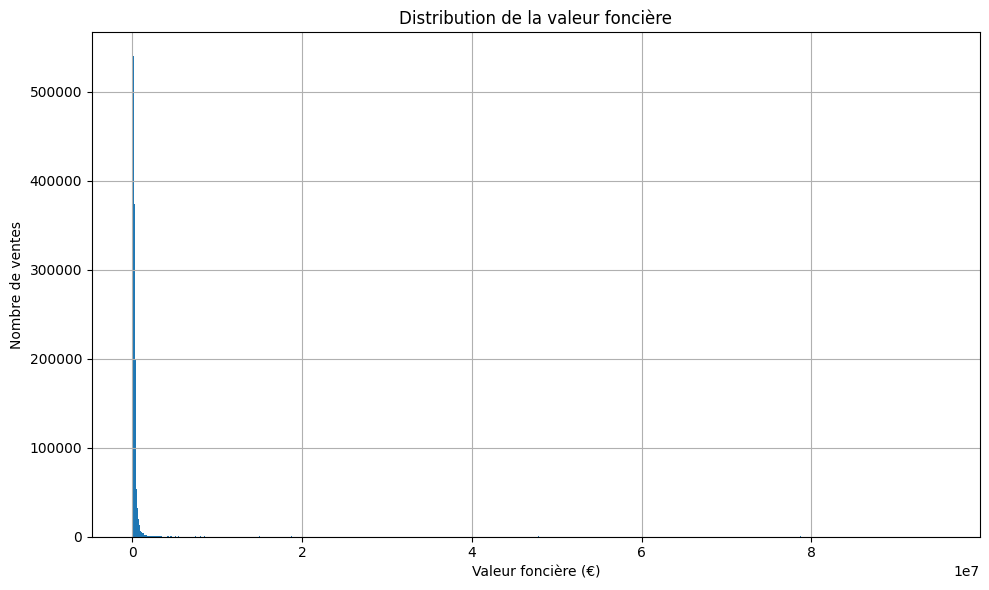

In [80]:
plt.figure(figsize=(10, 6))
plt.hist(dataset["Valeur fonciere"], bins= 1_000, log= False)
plt.title("Distribution de la valeur foncière")
plt.xlabel("Valeur foncière (€)")
plt.ylabel("Nombre de ventes")
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_4559/2856969314.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/eloi/miniconda3/envs/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


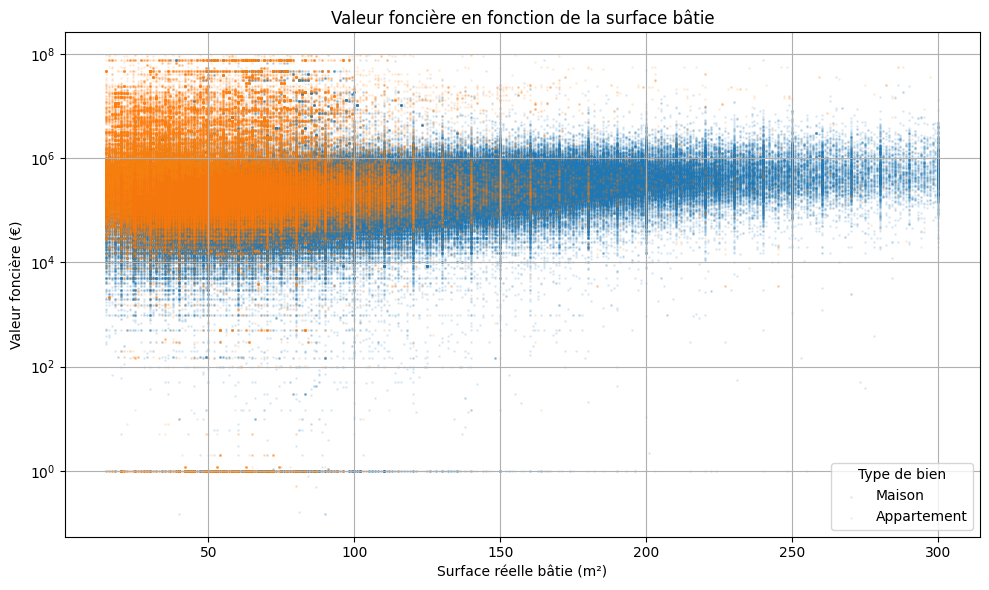

In [ ]:
plt.figure(figsize=(10, 6))

for type_local in dataset["Type local"].unique():
    subset = dataset[dataset["Type local"] == type_local]
    plt.scatter(subset["Surface reelle bati"], subset["Valeur fonciere"], label= type_local, alpha= .1, s= 1)
plt.title("Valeur foncière en fonction de la surface bâtie")
plt.xlabel("Surface réelle bâtie (m²)")
plt.ylabel("Valeur foncière (€)")
plt.grid(True)
plt.legend(title="Type de bien")
plt.yscale("log")
plt.tight_layout()
plt.show()

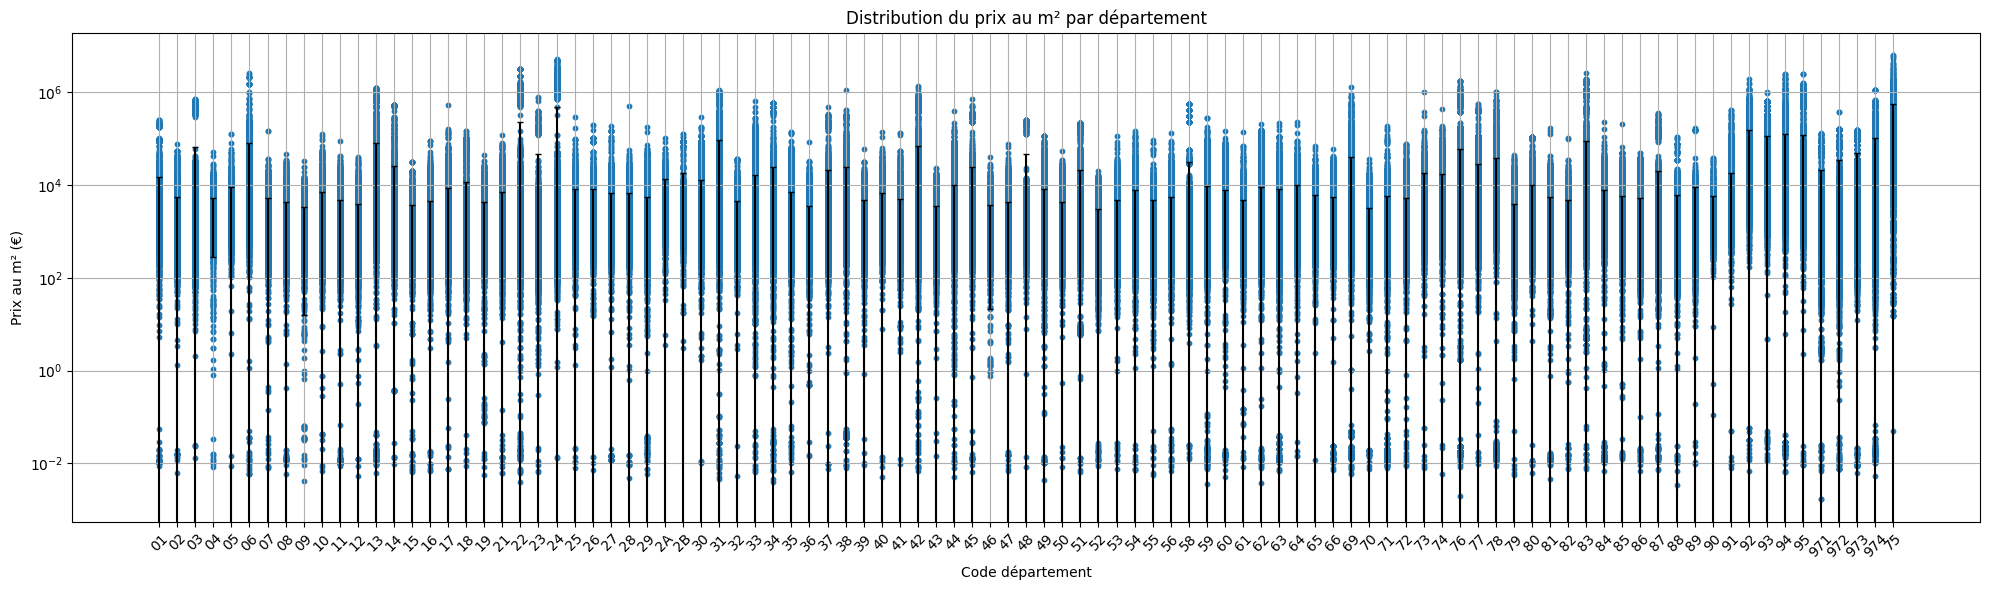

In [96]:
plt.figure(figsize=(20, 6))
plt.scatter(dataset["Code departement"], dataset["Prix au m2"], s= 10)
for departement in dataset["Code departement"].unique():
    subset = dataset[dataset["Code departement"] == departement]
    plt.errorbar(departement, np.mean(subset["Prix au m2"]), yerr= np.std(subset["Prix au m2"], ddof= 1), c= "k", capsize= 2)
plt.title("Distribution du prix au m² par département")
plt.xlabel("Code département")
plt.ylabel("Prix au m² (€)")
plt.xticks(rotation= 45)
plt.yscale("log")
plt.grid(True)
plt.tight_layout()
plt.show()

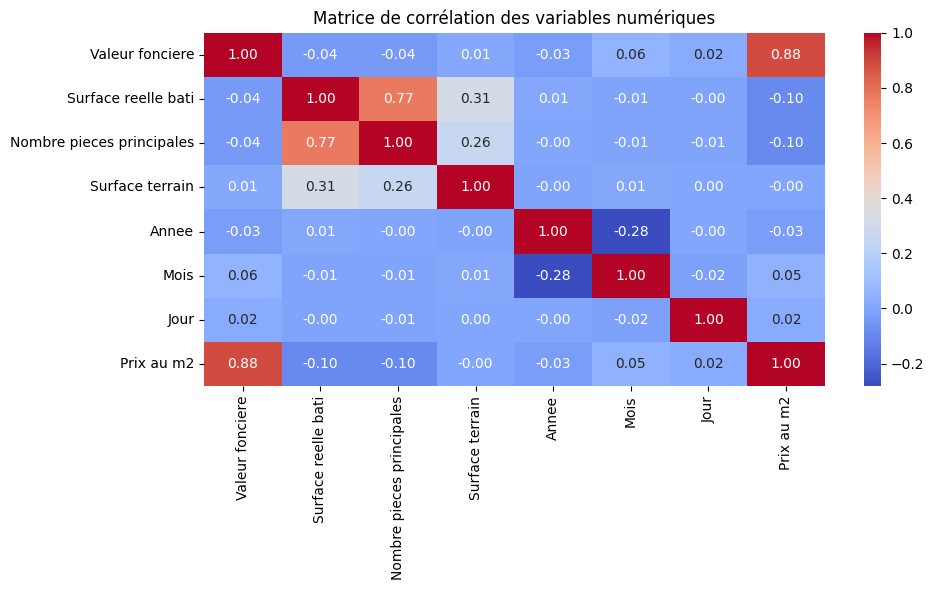

In [97]:

import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(dataset.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matrice de corrélation des variables numériques")
plt.tight_layout()
plt.show()
